# Setup

In [1]:
!gdown https://drive.google.com/uc?id=1Kat_WLKADObIUX4OMGoOelJsTYkL4Fx_

Downloading...
From: https://drive.google.com/uc?id=1Kat_WLKADObIUX4OMGoOelJsTYkL4Fx_
To: /content/data.csv
38.1MB [00:00, 49.8MB/s]


In [2]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import json
from collections import defaultdict
from collections import Counter

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
df = pd.read_csv('data.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  bool   
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

There are several variables, some of them have `NULL` values.<br>
With an overlook, we'll remove variables which are either the attributes captured while gathering the data or those which don't interact with the target variable.

In [5]:
df.drop(columns = ['uniq_id', 'crawl_timestamp', 'product_rating', 'overall_rating', 'product_url', 'image', 'is_FK_Advantage_product'], inplace = True)
df.head()

,product_name,product_category_tree,pid,retail_price,discounted_price,description,brand,product_specifications
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,Key Features of AW Bellies Sandals Wedges Heel...,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,Specifications of Sicons All Purpose Arnica Do...,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


We'll set the **SEED** for reproducibility.

In [6]:
SEED = 42

# Investigating each column

## Product_category_tree

It would be useful to look at what we want to predict first.

In [7]:
df['product_category_tree'].sample(10, random_state = SEED).values

array(['["Jewellery >> Accessories >> Brooches >> Avaron Projekt Moustache Brooch (Green)"]',
       '["Clothing >> Women\'s Clothing >> Lingerie, Sleep & Swimwear >> Bras >> Grafion Bras"]',
       '["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]',
       '["Computers >> Laptop Accessories >> USB Gadgets >> JRB USB Gadgets >> JRB 1042 Smallest Mobile Powered By OTG Enabled ..."]',
       '["Clothing >> Men\'s Clothing >> T-Shirts >> Northern Lights T-Shirts"]',
       '["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]',
       '["Cameras & Accessories >> Camera Accessories >> Battery chargers >> Pearstone Battery chargers"]',
       '["Bags, Wallets & Belts >> Bags >> Hand Bags >> JDK NOVELTY Hand Bags >> JDK NOVELTY Hand-held Bag (Beige)"]',
       '["Clothing >> Women\'s Clothing >> Western Wear >> Dresses & Skirts >> Dresses >> Jiiah Dresses"]',
       '["Beauty and Personal Care >> Bath and Spa >> Body and Essential Oils >

There are a lot of categories and sub-categories, It would be useful to take a look at how the count varies based on what the level of category is.<br>
Let's create some helper functions to achieve that.

In [8]:

def to_cat(df, level, return_new_df = False, COUNT_THRESH = 10):
    """
    Function which cleans & transforms a product's category to a single one.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        Dataframe to be cleaned
    level : int
        Integer which decides which category will be picked
    return_new_df : boolean
        Return new transformed df or not (default is `False`)
    COUNT_THRESH : int
        Threshold to drop categories having `COUNT_THRESH` samples, only applicable  
        when `return_new_df` is True

    Returns
    -------
    if `return_new_df == False`:
        new_category : list
            New category of samples according to `level`
        level_missing_ids : list
            ids of samples for which level was not found
    else:
        df : list
            Transformed dataframe with new `category_{LEVEL}` column
        level_missing_ids : list
            ids of samples for which level was not found
        below_thresh_index : list
            ids of samples which were dropped due to `COUNT_THRESH`

    """
    def clean_cat(s):
        """Cleans the category & keeps only text

        Parameters
        ----------
        s : string
            A single category extracted from the sample
        
        Returns
        -------
        category : string
            Cleaned text
        """
        pattern = re.compile(r'([a-zA-Z]+)')
        matches = pattern.findall(s)
        category = ''
        for match in matches:
            if len(match) > 1:
                category += f' {match}'
        category = string.capwords(category)
        if not category:
            raise Exception(f'Empty category -> {s}')
        return category

    def cat_to_level(row, level):
        """Returns the correct category at `level`

        Parameters
        ----------
        row : list
            A list containing raw categories of a single sample
        level : int
            Level of category, starts from `1`
        
        Returns
        -------
        category : string
            Correct cleaned category at Level `level` 
        """
        try:
            cat_levelled = row[level - 1]
        except IndexError:
            return False
        return clean_cat(cat_levelled)
    
    level_missing_ids = []
    new_category = []
    rows_cat = df.product_category_tree.apply(lambda x: x.split('>>')).to_list()

    for idx, row in enumerate(rows_cat):
        # Get correct category at a particular level
        cat_levelled = cat_to_level(row, level)
        if cat_levelled:
            new_category.append(cat_levelled)
        else:
            level_missing_ids.append(idx)

    print(f'Total Examples missing Category for Level_{level} -> {len(level_missing_ids)}')

    if return_new_df:
        # drop if missing category for level
        df.drop(labels = level_missing_ids, axis = 0, inplace = True)
        # Attach new column for category at a certain level
        df[f'category_{level}'] = new_category
        # Filter out categories having less samples according to threshold
        below_thresh_index = df.groupby(f'category_{LEVEL}').filter(lambda x: len(x) < COUNT_THRESH).index.to_list()
        df = df[~df.index.isin(below_thresh_index)]
        df.reset_index(drop = True, inplace = True)
        return df, level_missing_ids, below_thresh_index

    return new_category, level_missing_ids

def visualize_categories(cat_freq, level, top_freq = 5):
    """Plots a bar plot visualizing the top `top_freq` categories

    Parameters
    ----------
    cat_freq : list
        A sorted counter of the `category` 
    level : int
        Level of the category
    top_freq : int
        Top categories to display(default 5)
    """
    data = {
        'category' : [t[0] for t in cat_freq[:top_freq]],
        'freq' : [t[1] for t in cat_freq[:top_freq]]
    }
    data = pd.DataFrame.from_dict(data)
    plt.figure(figsize = (12, 6))
    plt.title(f'Level - {level}')
    sns.barplot(x = 'category',y = 'freq', data = data);

In [9]:
new_df = df.copy(deep = True)

In [10]:
# Let's see how many categories are there for each level
LEVEL = 1
cat, missing = to_cat(new_df, LEVEL)
cat_freq = Counter(cat).most_common()
print(f'\nTotal Categories for Level_{LEVEL} : {len(cat_freq)}\n')
print('Samples for each category')
cat_freq[:40]

Total Examples missing Category for Level_1 -> 0

Total Categories for Level_1 : 256

Samples for each category


[('Clothing', 6198),
 ('Jewellery', 3531),
 ('Footwear', 1227),
 ('Mobiles Accessories', 1099),
 ('Automotive', 1012),
 ('Home Decor Festive Needs', 929),
 ('Beauty And Personal Care', 710),
 ('Home Furnishing', 700),
 ('Kitchen Dining', 647),
 ('Computers', 578),
 ('Watches', 530),
 ('Baby Care', 483),
 ('Tools Hardware', 391),
 ('Toys School Supplies', 330),
 ('Pens Stationery', 313),
 ('Bags Wallets Belts', 265),
 ('Furniture', 180),
 ('Sports Fitness', 166),
 ('Cameras Accessories', 82),
 ('Home Improvement', 81),
 ('Health Personal Care Appliances', 43),
 ('Sunglasses', 40),
 ('Gaming', 35),
 ('Pet Supplies', 30),
 ('Home Kitchen', 24),
 ('Home Entertainment', 19),
 ('Ebooks', 15),
 ('Eyewear', 10),
 ('Clovia Women Full Coverage Bra', 9),
 ('Vishudh Printed Women Straight Kurta', 8),
 ('Lilliput Top Baby Girl Combo', 8),
 ('Olvin Aviator Sunglasses', 7),
 ('Clovia Women Shirt Bra', 6),
 ('Masara Solid Women Straight Kurta', 5),
 ('Dressberry Gold Synthetic Clutch', 4),
 ('Pu Good 

If we look at the categories count, till eyewear the categories make sense, after that the categories become too specific.<br>
For **Level1** we can see that there are total **256** categories.<br>
Let's visualize the top 5 categories.

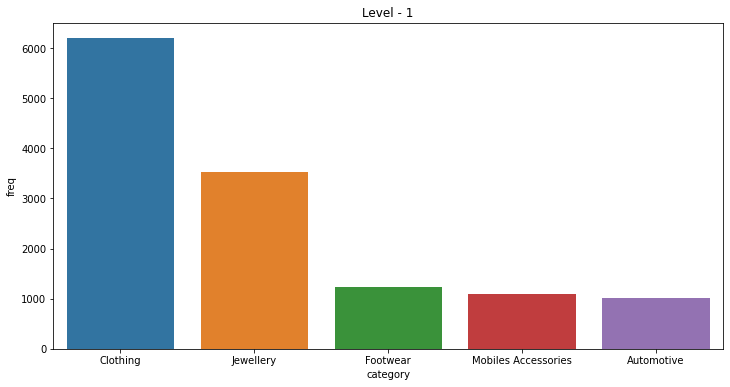

In [11]:
# Top Level 1 categories
visualize_categories(cat_freq, level = 1)

Seems clothing and jewellery dominates Level1, let's explore more granular categories.

Total Examples missing Category for Level_2 -> 328

Total Categories for Level_2 : 215



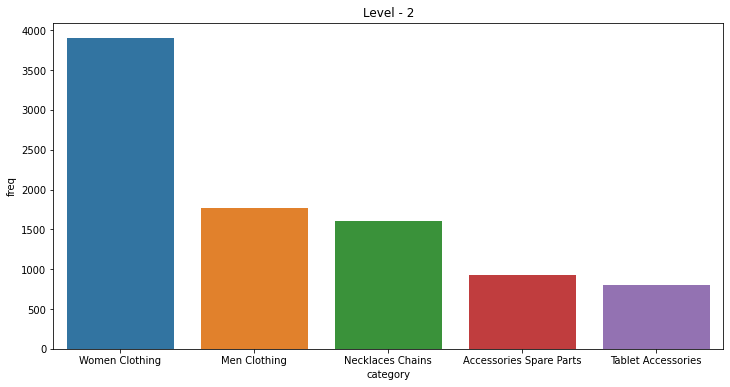

In [12]:
# Top Level 2 categories
LEVEL = 2
cat, missing = to_cat(new_df, LEVEL)
cat_freq = Counter(cat).most_common()
print(f'\nTotal Categories for Level_{LEVEL} : {len(cat_freq)}\n')
visualize_categories(cat_freq, level = 2)

In [13]:
# Top Level 3-6 categories
levels = [3, 4, 5, 6]
for level in levels:
    cat, missing = to_cat(new_df, level)
    cat_freq = Counter(cat).most_common()
    print(f'Total Categories for Level_{level} -> {len(cat_freq)}\n')

Total Examples missing Category for Level_3 -> 1457
Total Categories for Level_3 -> 865

Total Examples missing Category for Level_4 -> 5876
Total Categories for Level_4 -> 2282

Total Examples missing Category for Level_5 -> 10642
Total Categories for Level_5 -> 2491

Total Examples missing Category for Level_6 -> 15552
Total Categories for Level_6 -> 2199



As it's visible as we go down after `Level 2`, the examples having missing categories increase and total categories decreases and become more and more specific. Clothes become Kids clothes, men's wear, women's wear. So it would be sensible to consider `Level-1` for category while taking care of dropping the categories after `Eyewear`(count < 10) since they are very specific. Eg. `Vishudh Printed Women Straight Kurta` this category can be instead mapped to clothing.

In [14]:
LEVEL = 1
# We can use the examples which didn't make the cut later to predict a correct category on them(eg. Clothing)
# Instead of something like Vishudh Printed Women Straight Kurta

# both indexes should be mapped to original_df - `cat_missing_ids`, `below_thresh_index`

new_df, cat_missing_ids, below_thresh_index = to_cat(new_df, LEVEL, return_new_df = True, COUNT_THRESH = 10)
new_df.drop(columns = ['product_category_tree'], inplace = True)
new_df.info()        

Total Examples missing Category for Level_1 -> 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19668 entries, 0 to 19667
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_name            19668 non-null  object 
 1   pid                     19668 non-null  object 
 2   retail_price            19593 non-null  float64
 3   discounted_price        19593 non-null  float64
 4   description             19666 non-null  object 
 5   brand                   13804 non-null  object 
 6   product_specifications  19654 non-null  object 
 7   category_1              19668 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.2+ MB


In [15]:
new_df.head()

,product_name,pid,retail_price,discounted_price,description,brand,product_specifications,category_1
0,Alisha Solid Women's Cycling Shorts,SRTEH2FF9KEDEFGF,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
1,FabHomeDecor Fabric Double Sofa Bed,SBEEH3QGU7MFYJFY,32157.0,22646.0,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture
2,AW Bellies,SHOEH4GRSUBJGZXE,999.0,499.0,Key Features of AW Bellies Sandals Wedges Heel...,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear
3,Alisha Solid Women's Cycling Shorts,SRTEH2F6HUZMQ6SJ,699.0,267.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing
4,Sicons All Purpose Arnica Dog Shampoo,PSOEH3ZYDMSYARJ5,220.0,210.0,Specifications of Sicons All Purpose Arnica Do...,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies


In [16]:
# Final categories
new_df.category_1.unique()

array(['Clothing', 'Furniture', 'Footwear', 'Pet Supplies',
       'Pens Stationery', 'Sports Fitness', 'Beauty And Personal Care',
       'Bags Wallets Belts', 'Home Decor Festive Needs', 'Automotive',
       'Tools Hardware', 'Home Furnishing', 'Baby Care',
       'Mobiles Accessories', 'Watches', 'Toys School Supplies',
       'Jewellery', 'Sunglasses', 'Kitchen Dining', 'Home Kitchen',
       'Computers', 'Cameras Accessories',
       'Health Personal Care Appliances', 'Gaming', 'Home Improvement',
       'Home Entertainment', 'Eyewear', 'Ebooks'], dtype=object)

## Product_name
The `product_name` column contains the full name of the product which includes brand name, sometimes specs(20 W Charger..)

In [17]:
new_df['product_name'].sample(20, random_state = SEED).values   

array(['Petshop7 PS7DB0029 M Pet Bed', "Texco Girl's Vest",
       'Peach 3mm Premium Green Pan Kadhai 2.5 L',
       '925 Silver Silver Bracelet',
       "Varanga Casual Short Sleeve Printed Women's Top",
       "Ishin Designer Studio Women's Solid Casual Shirt",
       'Enthopia Back Cover for iPad Mini, iPad Mini 2, iPad Mini Retina',
       'United United Magic Silver 5 Ltr 5 L Pressure Cooker',
       "Alpha Lady Women's Printed Casual, Formal Shirt",
       'Smartpro 19.5v,3.9a Replacement Charger for Vaio Series VGN-CR420E/L 75 Adapter',
       "Bombay High Women's Checkered Casual Shirt",
       'Fabulloso Metal Dangle Earring',
       "Yepme Graphic Print Women's V-neck Purple T-Shirt",
       'PurpleYou Lace Embellished Blouse Material',
       'Voylla Yellow Gold Plated Alloy Necklace',
       "Bombay High Women's Striped Formal Shirt",
       'Nutcase Multicolor Column Floor Lamp',
       'BlueStone The Supra White Gold Diamond 18 K Ring',
       'Voylla Crystal Yellow Gold

Can it be useful for predicting category?
- Brand Names are a prefix sometimes which can help predict category, won't be always useful, since a brand can contain product across categories.
- Since the product name often contains information about what the product is, for instance if it is `clothing`, it may contain `Shirt`,`Top` etc. Let's clean ,standardize this feature.

In [18]:
%%time
# Keep track of stop words
all_words = defaultdict(lambda:1)
stopwords =  set(nltk.corpus.stopwords.words('english'))
for word in stopwords:
    all_words[word] = 0

tokens = []
# Lemmatization was tried using spacy
# Removed because there were not much words that needed to be lemmatized 
# and the pipeline took a lot of time ~30 mins for 20k
for s in new_df['product_name'].values:
    # keep only letters & spaces
    s = re.sub(r'[^a-zA-Z\s]+',' ', s)
    # remove one letter words
    s = re.sub(r'\b\w\b',' ', s)
    # clean
    s = re.sub(r'\s+',' ', s).strip()
    word_tokens = [token for token in s.split(' ') if all_words[token]]
    if not word_tokens:
        tokens.append(s)
    else:
        tokens.append(' '.join(word_tokens))

new_df.loc[:, ['name']] = tokens
new_df.drop(columns = ['product_name'], inplace = True)

CPU times: user 243 ms, sys: 3.6 ms, total: 247 ms
Wall time: 251 ms


In [19]:
new_df.head()

,pid,retail_price,discounted_price,description,brand,product_specifications,category_1,name
0,SRTEH2FF9KEDEFGF,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
1,SBEEH3QGU7MFYJFY,32157.0,22646.0,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati...",Furniture,FabHomeDecor Fabric Double Sofa Bed
2,SHOEH4GRSUBJGZXE,999.0,499.0,Key Features of AW Bellies Sandals Wedges Heel...,AW,"{""product_specification""=>[{""key""=>""Ideal For""...",Footwear,AW Bellies
3,SRTEH2F6HUZMQ6SJ,699.0,267.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
4,PSOEH3ZYDMSYARJ5,220.0,210.0,Specifications of Sicons All Purpose Arnica Do...,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",...",Pet Supplies,Sicons All Purpose Arnica Dog Shampoo


## Pid
Does `pid` have any coorelation with the items?

In [20]:
g_pid = new_df.groupby('category_1')
# Check out a random group
g_pid.get_group('Clothing').head(10)

,pid,retail_price,discounted_price,description,brand,product_specifications,category_1,name
0,SRTEH2FF9KEDEFGF,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
3,SRTEH2F6HUZMQ6SJ,699.0,267.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
5,SRTEH2FVVKRBAXHB,1199.0,479.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
8,SRTEH2FVUHAAVH9X,1199.0,479.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
10,SWIEHF3EF5PZAZUY,2299.0,910.0,Key Features of Carrel Printed Women's Fabric:...,Carrel,"{""product_specification""=>[{""key""=>""Neck"", ""va...",Clothing,Carrel Printed Women
12,SRTEH2FGBDJGX8FW,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
14,SRTEH2FECMGNZJXJ,999.0,379.0,Key Features of Alisha Solid Women's Cycling S...,Alisha,"{""product_specification""=>[{""key""=>""Number of ...",Clothing,Alisha Solid Women Cycling Shorts
17,SWIEHF3H7WG6VGMR,2499.0,999.0,Key Features of Carrel Printed Women's Fabric:...,Carrel,"{""product_specification""=>[{""key""=>""Neck"", ""va...",Clothing,Carrel Printed Women
20,SRTEH2FD3ANFFMHP,NaN,NaN,Alisha Solid Women's Cycling Shorts - Buy Blac...,Alisha,NaN,Clothing,Alisha Solid Women Cycling Shorts
21,TSHEHBHSKBJWHFNF,2400.0,1039.0,Specifications of dongli Printed Boy's Round N...,dongli,"{""product_specification""=>[{""key""=>""Sleeve"", ""...",Clothing,dongli Printed Boy Round Neck Shirt


We cannot engineer this feature with `category` as that would be data leakage since we are grouping by the target variable itself. 😅<br>
Another dumb classifer that we could try is take the first letter of `pid` and encode it, will try at the end if possible. <br>

In [21]:
new_df[new_df.duplicated(subset = ['pid'], keep = False)]

,pid,retail_price,discounted_price,description,brand,product_specifications,category_1,name
3119,JEAEGE8Q8GXYFTGU,1499.0,1099.0,Key Features of TIMBERLAKE Slim Fit Fit Women'...,TIMBERLAKE,"{""product_specification""=>[{""key""=>""Brand Colo...",Clothing,TIMBERLAKE Slim Fit Fit Women Blue Jeans
7618,ACCEJ6TESY7AFT5W,2399.0,1799.0,Key Features of Hako 60W Magsafe Laptop Charge...,Hako,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,Hako Magsafe Laptop Charger For APPLE MacBook ...
7665,ACCEJ6TESY7AFT5W,2399.0,1799.0,Key Features of Hako 60W Magsafe1 Laptop Charg...,Hako,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,Hako Magsafe Laptop Charger For APPLE MacBook ...
9178,JEAEGE8Q8GXYFTGU,1499.0,1099.0,Key Features of TIMBERLAKE Slim Fit Fit Women'...,TIMBERLAKE,"{""product_specification""=>[{""key""=>""Brand Colo...",Clothing,TIMBERLAKE Slim Fit Fit Women Blue Jeans


In [22]:
# Fix duplicates
new_df.drop_duplicates(subset = ['pid'], inplace = True, ignore_index = True, keep = 'first')
new_df.drop(columns = ['pid'], inplace = True)

## Retail_price & Discounted_price

In [23]:
new_df.describe()

,retail_price,discounted_price
count,19591.000000,19591.000000
mean,3000.109744,1987.901792
std,9079.195665,7390.900068
min,35.000000,35.000000
25%,666.000000,350.000000
50%,1040.000000,550.000000
75%,1999.000000,999.000000
max,571230.000000,571230.000000


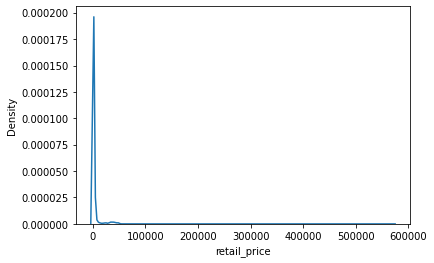

In [24]:
sns.kdeplot(new_df['retail_price']);

In [25]:
g_pid = new_df.groupby('category_1')
# Check out Mean & Std
print(g_pid.get_group('Clothing')['retail_price'].mean(), g_pid.get_group('Clothing')['retail_price'].std())
print(g_pid.get_group('Clothing')['discounted_price'].mean(), g_pid.get_group('Clothing')['discounted_price'].std())

1369.1974068071313 1638.6094732809597
714.2998379254457 977.0555353179425


The cost variables vary too much from the graph as well as looking at the SD of one category. We will not use it for now.

In [26]:
new_df.drop(columns = ['retail_price', 'discounted_price'], axis = 1, inplace = True)

## Description

In [27]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19666 entries, 0 to 19665
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   description             19664 non-null  object
 1   brand                   13802 non-null  object
 2   product_specifications  19652 non-null  object
 3   category_1              19666 non-null  object
 4   name                    19666 non-null  object
dtypes: object(5)
memory usage: 768.3+ KB


In [28]:
new_df = new_df.loc[new_df['description'].notna()].copy(deep = True)
new_df.reset_index(inplace = True, drop = True)

In [29]:
new_df['description'].sample(10, random_state = SEED).values

array(['Key Features of AdroitZ Premium Phone Socket Holder For Nokia N9 Type: Anti-slip Orientation: Portrait Mount Type Dashboard: Yes,AdroitZ Premium Phone Socket Holder For Nokia N9 (Red, Black) Price: Rs. 206 Description:- 1. The clips is adjustable: The max opening is 86mm, perfect fits for 5.7 inches mobile phones. 2. Elastic fixation design: With elastic fixation rubber band, the size of steer wheel won’t effect the installation. 3. Easy installation: No need extra tools, just a few seconds to finish it. 4. Safety: The device is highly compact with the steer wheel, can be moved freely, no security risk. 5. Protection: The device is embedded with soft silicone pad, which protect your phone from scratching or gash, etc.,Specifications of AdroitZ Premium Phone Socket Holder For Nokia N9 (Red, Black) General Mount Type Dashboard General Specifications In The Box Car Cradle Brand AdroitZ Model Premium Phone Socket Holder For Nokia N9 Color Red, Black',
       'Key Features of Anurad

There are a lot of garbage characters inside, we will clean it keeping only proper words and remove numbers.

In [30]:
def clean_desc(s):
    """
    Cleans the description
    & removes the stopwords

    Parameters
    ----------
    s : string
        A single string
    
    Returns
    -------
    s : string
        Joined tokens 
    """
    s = re.sub(r'[^a-zA-Z\s]+',' ', s)
    # remove one letter words
    s = re.sub(r'\b\w\b',' ', s)
    # clean
    s = re.sub(r'\s+',' ', s).strip()
    word_tokens = {token for token in s.split(' ') if all_words[token]}
    if not word_tokens:
        return s
    return ' '.join(word_tokens)

new_df['description'] = new_df['description'].apply(clean_desc)
new_df['description'].sample(10, random_state = SEED).values

array(['Box adjustable With soft tools extra Nokia Model Dashboard slip Cradle Protection perfect Yes Portrait Easy moved clips rubber steer gash mm Black fixation Color General AdroitZ fits max Red seconds protect phone band compact embedded pad Features Mount highly Premium Rs device phones Holder Safety scratching Phone For Type Brand opening etc The Elastic Key silicone No freely installation Anti size Specifications wheel Orientation security elastic risk finish inches mobile effect Price design In Car need Socket Description',
       'quality Box Fashion Artificial Replacement Dimensions Product brooch heart Silver Height offers Number For Features grip Ideal Women encrusted Days pearls Is Rs Art Brooch brooches The Contents colored Key sparkling made Precious Package Pack high Polished silver Warranty shaped metal Korean Covered Anuradha Under This Price Sales stones Jewellery mm In It Girls Width General Guarantee good Specifications',
       'Branded com Flipkart Only Online F

In [31]:
# Check out range of the description
new_df['description'].str.len().min(), new_df['description'].str.len().max()

(29, 2070)

## Brand

In [32]:
new_df['brand'].sample(10, random_state = SEED).values

array(['AdroitZ', 'Anuradha Art', 'Slim Fit', 'Cotonex', 'Beebay', nan,
       'Sri Bansilal Pearls', 'Vinnis', 'Fullcutdiamond',
       'Jadoo Collections'], dtype=object)

In [33]:
new_df['brand'].value_counts()

Allure Auto           469
Regular               313
Voylla                299
Slim                  288
TheLostPuppy          229
                     ... 
Bracketron              1
Golden Collections      1
Next Player             1
Shilpi                  1
Green-Black             1
Name: brand, Length: 3401, dtype: int64

In [34]:
# Brands of clothing
g_pid.get_group('Clothing')['brand'][:30]

0           Alisha
3           Alisha
5           Alisha
8           Alisha
10          Carrel
12          Alisha
14          Alisha
17          Carrel
20          Alisha
21          dongli
24             NaN
27             NaN
28             NaN
29        Indcrown
33           KAJCI
35     Pick Pocket
37             Oye
43        Roadster
56     Mario Gotze
62            Slim
63            Slim
71            Slim
87        Skanders
106        Regular
129        Regular
144            NaN
161     Skinny Fit
276     Traditions
278     Eccellente
280     Traditions
Name: brand, dtype: object

In [35]:
new_df.drop(columns = ['brand'], axis = 1, inplace = True)

We will not use `brand` as there are too many and one brand can have multiple products. And it seems brand variable is noisy as sometimes `size` of the product is also considered as brand.

## Product_specifications

In [36]:
new_df['product_specifications'].sample(10, random_state = SEED).values

array(['{"product_specification"=>[{"key"=>"Mount Type", "value"=>"Dashboard"}, {"key"=>"In The Box", "value"=>"Car Cradle"}, {"key"=>"Brand", "value"=>"AdroitZ"}, {"key"=>"Model", "value"=>"Premium Phone Socket Holder For Nokia N9"}, {"key"=>"Color", "value"=>"Red, Black"}]}',
       '{"product_specification"=>[{"key"=>"Sales Package", "value"=>"1 Brooch"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 1"}, {"key"=>"Precious/Artificial Jewellery", "value"=>"Fashion Jewellery"}, {"key"=>"Ideal For", "value"=>"Women Girls"}, {"key"=>"Width", "value"=>"40 mm"}, {"key"=>"Height", "value"=>"45 mm"}, {"value"=>"The Product Is Covered Under 30 Days Replacement Guarantee."}]}',
       '{"product_specification"=>[{"key"=>"Pattern", "value"=>"Checkered"}, {"key"=>"Occasion", "value"=>"Casual"}, {"key"=>"Ideal For", "value"=>"Women\'s"}, {"key"=>"Sleeve", "value"=>"Half Sleeve"}, {"key"=>"Brand Fit", "value"=>"Slim Fit"}, {"key"=>"Collar", "value"=>"Spread"}, {"key"=>"Fabric",

In [37]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19664 entries, 0 to 19663
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   description             19664 non-null  object
 1   product_specifications  19650 non-null  object
 2   category_1              19664 non-null  object
 3   name                    19664 non-null  object
dtypes: object(4)
memory usage: 614.6+ KB


In [38]:
def clean_product_spec(s):
    """Cleans the variable 
    & joins to have a semantic meaning

    Parameters
    ----------
    s : string
        A single product spec
    
    Returns
    -------
    parsed : string
        parsed string
    """
    if pd.isna(s):
        return np.nan
    pattern = re.compile(r'"key"=>"(.*?)".*?"value"=>"(.*?)"')
    matches = pattern.finditer(s)
    parsed = ""
    for match in matches:
        key = match.group(1)
        value = match.group(2)
        parsed += f"{key} is {value}, "
    parsed = parsed.strip()[:-1]
    if parsed:
        return parsed
    return np.nan

Check out a Random example to see which feature can be used as a sequence having meaning.

In [39]:
RANDOM_EXAMPLE = 30

In [40]:
new_df['product_specifications'].map(clean_product_spec)[RANDOM_EXAMPLE]

'Ruling is Ruled, Model id is NB00664, Type is Notebook, GSM is 75, Cover Type is 300 GSM Hard Laminated Cover, No. of Pages is 160, Brand Name is Shopmania, Binding is Spiral Bound, Color is Multicolor, Size is A5, Length is 9 inch, Width is 6 inch, Sales Package is 1 Notebook'

In [41]:
new_df['description'][RANDOM_EXAMPLE]

'GSM Cover inch Box Laminated Dimensions Shopmania Pages used Writing Can Band Ruling Model pad Features Hard Type Brand Name Music Size Special Bound Notepad Package Binding Length No NB Multicolor Sales id In Diary Spiral Color General Notebook Ruled Width Specifications'

The `Product Spec` feature looks promising compared to `description`.

In [42]:
new_df['product_spec'] = new_df['product_specifications'].apply(clean_product_spec)
new_df.drop(columns = ['product_specifications'], inplace = True)
new_df = new_df[new_df['product_spec'].notna()].copy(deep = True)
new_df.reset_index(inplace = True, drop = True)

In [43]:
new_df.head()

,description,category_1,name,product_spec
0,Box Style Red Lycra Details Fabric Bleach ALTH...,Clothing,Alisha Solid Women Cycling Shorts,Number of Contents in Sales Package is Pack of...
1,quality Box hard professionally direct replace...,Furniture,FabHomeDecor Fabric Double Sofa Bed,Installation & Demo Details is Installation an...
2,inch Box stains shoe Red Product Details Of Al...,Footwear,AW Bellies,"Ideal For is Women, Occasion is Casual, Color ..."
3,Box Style Red Lycra Details Fabric Bleach Addi...,Clothing,Alisha Solid Women Cycling Shorts,Number of Contents in Sales Package is Pack of...
4,Box Fashion Form Number Quantity Model Fragran...,Pet Supplies,Sicons All Purpose Arnica Dog Shampoo,"Pet Type is Dog, Brand is Sicons, Quantity is ..."


In [44]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19597 entries, 0 to 19596
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   19597 non-null  object
 1   category_1    19597 non-null  object
 2   name          19597 non-null  object
 3   product_spec  19597 non-null  object
dtypes: object(4)
memory usage: 612.5+ KB


In [45]:
new_df[new_df.duplicated()]

,description,category_1,name,product_spec
138,Rs Ladies Day Boots Replacement Free On Delive...,Footwear,Kielz Ladies Boots,"Ideal For is Women, Occasion is Casual, Sole M..."
140,Rs Day Boots Replacement Free Gambe On Deliver...,Footwear,Belle Gambe Boots,"Occasion is Casual, Ideal For is Women, Heel H..."
174,Rs Ladies Day Boots Replacement Free On Delive...,Footwear,Kielz Ladies Boots,"Ideal For is Women, Occasion is Casual, Sole M..."
206,Rs Day Boots Replacement Free Remson On Delive...,Footwear,Remson India Boots,"Ideal For is Women, Occasion is Casual, Heel H..."
213,Rs Ladies Day Boots Replacement Free On Delive...,Footwear,Kielz Ladies Boots,"Ideal For is Women, Occasion is Casual, Sole M..."
...,...,...,...,...
19583,shipping Replacement WallDesign prices Only Pr...,Baby Care,WallDesign Small Vinyl Sticker,Number of Contents in Sales Package is Pack of...
19585,shipping Replacement WallDesign prices Only Pr...,Baby Care,WallDesign Small Vinyl Sticker,Number of Contents in Sales Package is Pack of...
19586,shipping Replacement prices Medium Only Produc...,Baby Care,store Medium Paper Sticker,"Sales Package is Wall Sticker, Shape is Rectan..."
19589,shipping Replacement prices Medium Only Produc...,Baby Care,store Medium Paper Sticker,"Sales Package is Wall Sticker, Shape is Rectan..."


Clean up the duplicates

In [46]:
new_df.drop_duplicates(inplace=True, ignore_index = True)

In [47]:
# cleaned data for modelling
new_df.to_csv('processed_data.csv')

We can predict on this as they **don't have the correct level of target variable**.

In [48]:
# Missing category for Level `LEVEL`
if cat_missing_ids:
    with open("cat_missing_ids.txt", "w") as fp:
        json.dump(cat_missing_ids, fp)

# Samples whose category has < COUNT_THRESH samples
if below_thresh_index:
    with open("below_thresh_index.txt", "w") as fp:
        json.dump(below_thresh_index, fp)